# Setup

## Install Detectron2

In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
# !git clone 'https://github.com/facebookresearch/detectron2'
# dist = distutils.core.run_setup("./detectron2/setup.py")
# !python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
# sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 274 kB 6.2 MB/s eta 0:00:01
  Created wheel for pyyaml: filename=PyYAML-5.1-cp38-cp38-linux_x86_64.whl size=44074 sha256=2e99655f36b7c6c9d793773ea549adb68cbe6515fd4a9ade21180d4b6917946e
  Stored in directory: /home/shabanza/.cache/pip/wheels/52/dd/2b/10ff8b0ac81b93946bb5fb9e6749bae2dac246506c8774e6cf
Successfully built pyyaml
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.7.0 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-x8w82efd
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-x8w82efd
     |████████

In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Mon_May__3_19:15:13_PDT_2021
Cuda compilation tools, release 11.3, V11.3.109
Build cuda_11.3.r11.3/compiler.29920130_0
torch:  1.10 ; cuda:  cu113
detectron2: 0.6


## Install Mask2Former

In [2]:
# clone and install Mask2Former
# !git clone https://github.com/facebookresearch/Mask2Former.git
%cd Mask2Former
%pip install -U opencv-python
# %pip install git+https://github.com/cocodataset/panopticapi.git
%pip install -r requirements.txt
%cd mask2former/modeling/pixel_decoder/ops
!python setup.py build install

/scratch/shabanza/segmentation/Mask2Former
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 61.7 MB 6.0 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 2.3 MB 6.1 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 108.1 MB/s eta 0:00:01
     |████████████████████████████████| 73 kB 8.1 MB/s s eta 0:00:01
     |████████████████████████████████| 1.3 MB 78.4 MB/s eta 0:00:01
     |████████████████████████████████| 268 kB 96.3 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  NOTE: The current PATH contains path(s) starting with `~`, which may not be expanded by all applications.
Note: you may need to restart the kernel to use updated packages.
/scratch/shabanza/segmentation/

In [3]:
%cd /scratch/shabanza/segmentation/Mask2Former
%cd mask2former/modeling/pixel_decoder/ops
!sudo sh make.sh
%cd /scratch/shabanza/segmentation/Mask2Former

/scratch/shabanza/segmentation/Mask2Former
/scratch/shabanza/segmentation/Mask2Former/mask2former/modeling/pixel_decoder/ops
running build
running build_py
running build_ext
building 'MultiScaleDeformableAttention' extension
Emitting ninja build file /scratch/shabanza/segmentation/Mask2Former/mask2former/modeling/pixel_decoder/ops/build/temp.linux-x86_64-3.8/build.ninja...
Compiling objects...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
g++ -pthread -shared -B /opt/conda/compiler_compat -L/opt/conda/lib -Wl,-rpath=/opt/conda/lib -Wl,--no-as-needed -Wl,--sysroot=/ /scratch/shabanza/segmentation/Mask2Former/mask2former/modeling/pixel_decoder/ops/build/temp.linux-x86_64-3.8/scratch/shabanza/segmentation/Mask2Former/mask2former/modeling/pixel_decoder/ops/src/vision.o /scratch/shabanza/segmentation/Mask2Former/mask2former/modeling/pixel_decoder/ops/build/temp.linux-x86_64-3.8/scratch/shabanza/segment

For gccxx not found error:
> sudo apt-get update

> sudo apt-get install software-properties-common

> sudo add-apt-repository ppa:ubuntu-toolchain-r/test

> sudo apt-get upgrade libstdc++6

For libGL error:
> sudo apt-get install ffmpeg libsm6 libxext6  -y

## Imports

In [1]:
# import some common libraries
import torch
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
torch.cuda.empty_cache()

In [4]:
# You may need to restart your runtime prior to this, to let your installation take effect
%cd Mask2Former
# Some basic setup:
# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()
setup_logger(name="mask2former")


# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog
from detectron2.projects.deeplab import add_deeplab_config
coco_metadata = MetadataCatalog.get("coco_2017_val_panoptic")

# import Mask2Former project
from mask2former import add_maskformer2_config

/home/yalda/IVRL_backup/shabanza_scratch/segmentation/Mask2Former


# Dataset

In [5]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from src.dataset.register_comic_instance import *

registering comic ...
loading sinergia json ...
Sinergia Json loaded.
registering placid ...


100%|██████████| 47256/47256 [00:00<00:00, 1063029.11it/s]


registering yves ...


100%|██████████| 47256/47256 [00:00<00:00, 1191349.63it/s]


In [6]:
dataset_name = DATASET_NAME

dataset_dicts = DatasetCatalog.get(dataset_name)
metadata = MetadataCatalog.get(dataset_name)

[08/31 15:52:15 d2.data.datasets.coco]: Loading /home/yalda/IVRL_backup/shabanza_sinergia/datasets/sinergia/coco/annotations/instances_default_modified.json takes 1.42 seconds.
[08/31 15:52:15 d2.data.datasets.coco]: Loaded 282 images in COCO format from /home/yalda/IVRL_backup/shabanza_sinergia/datasets/sinergia/coco/annotations/instances_default_modified.json


In [7]:
placid_dataset_dicts = DatasetCatalog.get(PLACID_NAME)
placid_metadata = MetadataCatalog.get(PLACID_NAME)

[08/31 15:52:17 d2.data.datasets.coco]: Loading /home/yalda/IVRL_backup/shabanza_sinergia/datasets/sinergia/coco/annotations/instances_placid.json takes 1.12 seconds.
[08/31 15:52:17 d2.data.datasets.coco]: Loaded 154 images in COCO format from /home/yalda/IVRL_backup/shabanza_sinergia/datasets/sinergia/coco/annotations/instances_placid.json


In [8]:
yves_dataset_dicts = DatasetCatalog.get(YVES_NAME)
yves_metadata = MetadataCatalog.get(YVES_NAME)

[08/31 15:52:17 d2.data.datasets.coco]: Loaded 128 images in COCO format from /home/yalda/IVRL_backup/shabanza_sinergia/datasets/sinergia/coco/annotations/instances_yves.json


# Finetune

In [9]:
from src.evaluation.instance_evaluation import *
from src.evaluation.semantic_evaluation import *
from src.evaluation.helpers import *
from src.dataset.register_train_test import *
from src.train.config import *
from src.train.comic_trainer import *

## Placid

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
%cd /home/yalda/IVRL_backup/shabanza_scratch/segmentation

cfg = setup(data_mode='placid', cropped=True)

/home/yalda/IVRL_backup/shabanza_scratch/segmentation
sinergia_placid_instances
registering train test dataset ...
[08/31 15:52:26 d2.data.datasets.coco]: Loading /home/yalda/IVRL_backup/shabanza_sinergia/datasets/sinergia/coco/annotations/instances_placid.json takes 1.70 seconds.
[08/31 15:52:26 d2.data.datasets.coco]: Loaded 154 images in COCO format from /home/yalda/IVRL_backup/shabanza_sinergia/datasets/sinergia/coco/annotations/instances_placid.json
sinergia_placid_instances_train 123
Collect all panels for mode train ...


100%|██████████| 123/123 [05:04<00:00,  2.48s/it]


sinergia_placid_instances_test 31
Collect all panels for mode test ...


 16%|█▌        | 5/31 [00:10<00:55,  2.13s/it]

In [ ]:
data_loader = ComicTrainer.build_train_loader(cfg)

[08/31 15:20:14 d2.data.build]: Removed 0 images with no usable annotations. 1969 images left.
[08/31 15:20:14 d2.data.build]: Using training sampler TrainingSampler
[08/31 15:20:14 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/31 15:20:14 d2.data.common]: Serializing 1969 elements to byte tensors and concatenating them all ...


[08/31 15:20:18 d2.data.common]: Serialized dataset takes 833.03 MiB


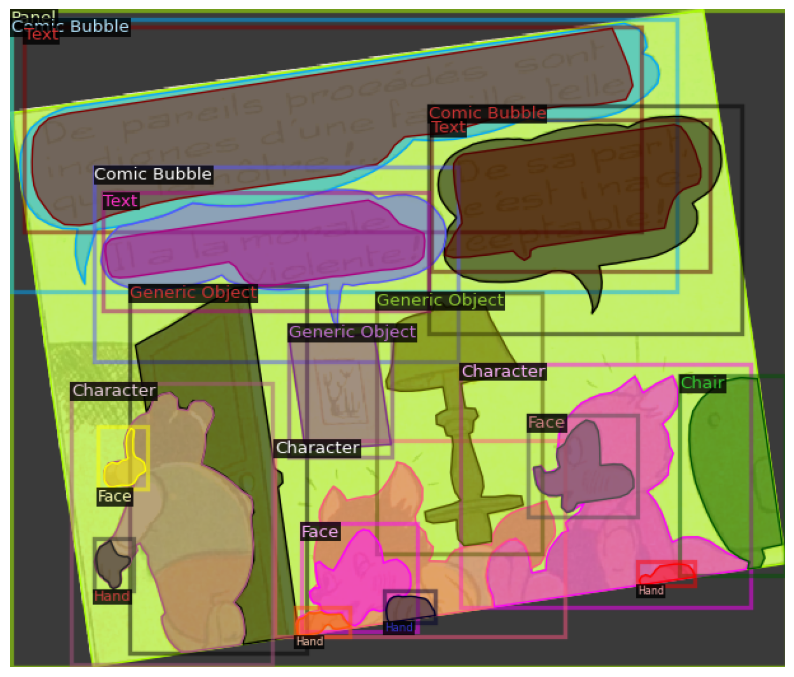

In [26]:
batch = next(iter(data_loader))
im = batch[1]['image'].cpu().numpy().transpose((1, 2, 0))
v = Visualizer(im, metadata, scale=1.2, instance_mode=ColorMode.IMAGE_BW)
r = v.draw_dataset_dict(batch[1]).get_image()
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(r)

In [24]:
model = ComicTrainer.build_model(cfg)

[08/31 15:20:24 d2.engine.defaults]: Model:
MaskFormer(
  (backbone): D2SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=192, out_features=576, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=192, out_features=192, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (

In [27]:
import wandb

wandb.init(
    project="comic-seg",
    config={
        "panel_wise": True,
        "dataset": 'placid',
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yaldashbz. Use `wandb login --relogin` to force relogin


In [29]:
from src.train.plain_train_net import do_train


do_train(cfg, model, resume=False, distributed=False, data_loader=data_loader)

WARNING [08/31 15:26:17 d2.solver.build]: SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.
[08/31 15:26:17 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/maskformer/mask2former/coco/instance/maskformer2_swin_large_IN21k_384_bs16_100ep/model_final_e5f453.pkl ...


WARNING [08/31 15:26:18 mask2former.modeling.transformer_decoder.mask2former_transformer_decoder]: Weight format of MultiScaleMaskedTransformerDecoder have changed! Please upgrade your models. Applying automatic conversion now ...
[08/31 15:26:18 detectron2]: Starting training from iteration 0


19it [00:08,  2.61it/s]

[08/31 15:26:26 d2.utils.events]:  iter: 19  total_loss: 106.9  loss_ce: 8.733  loss_mask: 0.09949  loss_dice: 3.777  loss_ce_0: 4.264  loss_mask_0: 0.006196  loss_dice_0: 0.4406  loss_ce_1: 8.047  loss_mask_1: 0.006151  loss_dice_1: 0.9134  loss_ce_2: 8.372  loss_mask_2: 0.0222  loss_dice_2: 2.904  loss_ce_3: 8.464  loss_mask_3: 0.05009  loss_dice_3: 3.113  loss_ce_4: 8.135  loss_mask_4: 0.06068  loss_dice_4: 3.407  loss_ce_5: 8.145  loss_mask_5: 0.07745  loss_dice_5: 3.55  loss_ce_6: 8.446  loss_mask_6: 0.103  loss_dice_6: 3.639  loss_ce_7: 8.424  loss_mask_7: 0.0514  loss_dice_7: 3.181  loss_ce_8: 8.45  loss_mask_8: 0.1047  loss_dice_8: 3.537     lr: 0.00025  max_mem: 5925M


39it [00:14,  3.31it/s]

[08/31 15:26:33 d2.utils.events]:  eta: 0:05:05  iter: 39  total_loss: 107.3  loss_ce: 8.63  loss_mask: 0.09658  loss_dice: 3.66  loss_ce_0: 4.174  loss_mask_0: 0.005156  loss_dice_0: 0.4837  loss_ce_1: 8.22  loss_mask_1: 0.006824  loss_dice_1: 0.7184  loss_ce_2: 8.116  loss_mask_2: 0.02581  loss_dice_2: 2.504  loss_ce_3: 8.407  loss_mask_3: 0.05793  loss_dice_3: 3.466  loss_ce_4: 8.226  loss_mask_4: 0.06981  loss_dice_4: 3.359  loss_ce_5: 8.246  loss_mask_5: 0.05322  loss_dice_5: 3.426  loss_ce_6: 8.587  loss_mask_6: 0.08516  loss_dice_6: 3.385  loss_ce_7: 8.449  loss_mask_7: 0.06965  loss_dice_7: 3.147  loss_ce_8: 8.527  loss_mask_8: 0.08691  loss_dice_8: 3.472     lr: 0.00025  max_mem: 5925M


59it [00:20,  4.01it/s]

[08/31 15:26:38 d2.utils.events]:  eta: 0:04:26  iter: 59  total_loss: 105.4  loss_ce: 8.764  loss_mask: 0.0735  loss_dice: 3.553  loss_ce_0: 4.192  loss_mask_0: 0.005416  loss_dice_0: 0.5686  loss_ce_1: 8.48  loss_mask_1: 0.006452  loss_dice_1: 0.5818  loss_ce_2: 8.401  loss_mask_2: 0.02297  loss_dice_2: 2.946  loss_ce_3: 8.489  loss_mask_3: 0.05307  loss_dice_3: 3.202  loss_ce_4: 8.589  loss_mask_4: 0.04593  loss_dice_4: 3.395  loss_ce_5: 8.474  loss_mask_5: 0.06485  loss_dice_5: 3.274  loss_ce_6: 8.794  loss_mask_6: 0.08275  loss_dice_6: 3.265  loss_ce_7: 8.789  loss_mask_7: 0.05137  loss_dice_7: 3.002  loss_ce_8: 8.952  loss_mask_8: 0.05978  loss_dice_8: 3.179     lr: 0.00025  max_mem: 5925M


79it [00:25,  2.82it/s]

[08/31 15:26:44 d2.utils.events]:  eta: 0:04:19  iter: 79  total_loss: 108.6  loss_ce: 8.636  loss_mask: 0.1028  loss_dice: 3.463  loss_ce_0: 4.041  loss_mask_0: 0.007501  loss_dice_0: 0.555  loss_ce_1: 8.502  loss_mask_1: 0.007556  loss_dice_1: 0.9397  loss_ce_2: 8.378  loss_mask_2: 0.0278  loss_dice_2: 3.022  loss_ce_3: 8.628  loss_mask_3: 0.06282  loss_dice_3: 3.297  loss_ce_4: 8.43  loss_mask_4: 0.0649  loss_dice_4: 3.398  loss_ce_5: 8.47  loss_mask_5: 0.08488  loss_dice_5: 3.444  loss_ce_6: 8.725  loss_mask_6: 0.08926  loss_dice_6: 3.432  loss_ce_7: 8.692  loss_mask_7: 0.06954  loss_dice_7: 3.063  loss_ce_8: 8.672  loss_mask_8: 0.09461  loss_dice_8: 3.411     lr: 0.00025  max_mem: 5925M


99it [00:31,  3.62it/s]

[08/31 15:26:50 d2.utils.events]:  eta: 0:04:14  iter: 99  total_loss: 117.9  loss_ce: 9.475  loss_mask: 0.1038  loss_dice: 3.895  loss_ce_0: 4.648  loss_mask_0: 0.006212  loss_dice_0: 0.4369  loss_ce_1: 9.087  loss_mask_1: 0.00655  loss_dice_1: 1.092  loss_ce_2: 8.78  loss_mask_2: 0.03229  loss_dice_2: 3.319  loss_ce_3: 9.26  loss_mask_3: 0.08223  loss_dice_3: 3.473  loss_ce_4: 9.081  loss_mask_4: 0.07036  loss_dice_4: 3.483  loss_ce_5: 9.175  loss_mask_5: 0.08595  loss_dice_5: 3.409  loss_ce_6: 9.277  loss_mask_6: 0.0899  loss_dice_6: 3.582  loss_ce_7: 9.364  loss_mask_7: 0.06982  loss_dice_7: 3.344  loss_ce_8: 9.518  loss_mask_8: 0.103  loss_dice_8: 3.574     lr: 0.00025  max_mem: 5925M


119it [00:36,  3.55it/s]

[08/31 15:26:55 d2.utils.events]:  eta: 0:04:03  iter: 119  total_loss: 104.1  loss_ce: 7.8  loss_mask: 0.103  loss_dice: 3.427  loss_ce_0: 3.626  loss_mask_0: 0.01162  loss_dice_0: 0.6719  loss_ce_1: 7.764  loss_mask_1: 0.01143  loss_dice_1: 1.021  loss_ce_2: 7.606  loss_mask_2: 0.02686  loss_dice_2: 2.911  loss_ce_3: 7.691  loss_mask_3: 0.08218  loss_dice_3: 3.027  loss_ce_4: 7.423  loss_mask_4: 0.06901  loss_dice_4: 3.193  loss_ce_5: 7.601  loss_mask_5: 0.0774  loss_dice_5: 3.466  loss_ce_6: 7.618  loss_mask_6: 0.121  loss_dice_6: 3.376  loss_ce_7: 7.601  loss_mask_7: 0.07598  loss_dice_7: 2.999  loss_ce_8: 7.841  loss_mask_8: 0.09283  loss_dice_8: 3.446     lr: 0.00025  max_mem: 5925M


139it [00:42,  3.83it/s]

[08/31 15:27:01 d2.utils.events]:  eta: 0:04:19  iter: 139  total_loss: 111.4  loss_ce: 8.869  loss_mask: 0.09473  loss_dice: 3.68  loss_ce_0: 4.516  loss_mask_0: 0.004742  loss_dice_0: 0.4171  loss_ce_1: 8.591  loss_mask_1: 0.006131  loss_dice_1: 0.9632  loss_ce_2: 8.63  loss_mask_2: 0.03367  loss_dice_2: 2.843  loss_ce_3: 8.834  loss_mask_3: 0.06499  loss_dice_3: 3.324  loss_ce_4: 8.557  loss_mask_4: 0.09273  loss_dice_4: 3.493  loss_ce_5: 8.732  loss_mask_5: 0.06388  loss_dice_5: 3.537  loss_ce_6: 8.818  loss_mask_6: 0.0972  loss_dice_6: 3.49  loss_ce_7: 8.7  loss_mask_7: 0.07807  loss_dice_7: 3.217  loss_ce_8: 8.736  loss_mask_8: 0.09603  loss_dice_8: 3.599     lr: 0.00025  max_mem: 5925M


159it [00:49,  3.69it/s]

[08/31 15:27:08 d2.utils.events]:  eta: 0:04:40  iter: 159  total_loss: 124.1  loss_ce: 9.948  loss_mask: 0.1001  loss_dice: 3.84  loss_ce_0: 4.982  loss_mask_0: 0.00495  loss_dice_0: 0.3643  loss_ce_1: 9.402  loss_mask_1: 0.01066  loss_dice_1: 1.021  loss_ce_2: 9.238  loss_mask_2: 0.03469  loss_dice_2: 2.906  loss_ce_3: 9.72  loss_mask_3: 0.06448  loss_dice_3: 3.622  loss_ce_4: 9.551  loss_mask_4: 0.07904  loss_dice_4: 3.761  loss_ce_5: 9.586  loss_mask_5: 0.0826  loss_dice_5: 3.898  loss_ce_6: 9.829  loss_mask_6: 0.1302  loss_dice_6: 3.725  loss_ce_7: 9.899  loss_mask_7: 0.06817  loss_dice_7: 3.643  loss_ce_8: 10.09  loss_mask_8: 0.08239  loss_dice_8: 3.832     lr: 0.00025  max_mem: 5925M


179it [00:55,  3.65it/s]

[08/31 15:27:14 d2.utils.events]:  eta: 0:04:00  iter: 179  total_loss: 103.8  loss_ce: 8.398  loss_mask: 0.08302  loss_dice: 3.331  loss_ce_0: 3.952  loss_mask_0: 0.01061  loss_dice_0: 0.5096  loss_ce_1: 7.861  loss_mask_1: 0.007029  loss_dice_1: 0.7484  loss_ce_2: 8.268  loss_mask_2: 0.03318  loss_dice_2: 2.6  loss_ce_3: 8.052  loss_mask_3: 0.05421  loss_dice_3: 3.047  loss_ce_4: 8.149  loss_mask_4: 0.04566  loss_dice_4: 3.463  loss_ce_5: 8.173  loss_mask_5: 0.05397  loss_dice_5: 3.479  loss_ce_6: 8.32  loss_mask_6: 0.07823  loss_dice_6: 3.235  loss_ce_7: 8.378  loss_mask_7: 0.05247  loss_dice_7: 2.758  loss_ce_8: 8.348  loss_mask_8: 0.06061  loss_dice_8: 3.141     lr: 0.00025  max_mem: 5925M


199it [01:01,  2.96it/s]

[08/31 15:27:20 d2.utils.events]:  eta: 0:03:59  iter: 199  total_loss: 116  loss_ce: 9.41  loss_mask: 0.1304  loss_dice: 3.623  loss_ce_0: 4.638  loss_mask_0: 0.005769  loss_dice_0: 0.4665  loss_ce_1: 8.439  loss_mask_1: 0.004822  loss_dice_1: 0.7789  loss_ce_2: 8.454  loss_mask_2: 0.01468  loss_dice_2: 2.807  loss_ce_3: 8.981  loss_mask_3: 0.08293  loss_dice_3: 3.506  loss_ce_4: 8.731  loss_mask_4: 0.08579  loss_dice_4: 3.726  loss_ce_5: 8.735  loss_mask_5: 0.08299  loss_dice_5: 3.765  loss_ce_6: 8.903  loss_mask_6: 0.1193  loss_dice_6: 3.591  loss_ce_7: 9.276  loss_mask_7: 0.07803  loss_dice_7: 3.45  loss_ce_8: 9.173  loss_mask_8: 0.1072  loss_dice_8: 3.63     lr: 0.00025  max_mem: 5925M


219it [01:07,  3.92it/s]

[08/31 15:27:26 d2.utils.events]:  eta: 0:04:09  iter: 219  total_loss: 111.1  loss_ce: 9.294  loss_mask: 0.09346  loss_dice: 4.018  loss_ce_0: 4.563  loss_mask_0: 0.00647  loss_dice_0: 0.4334  loss_ce_1: 8.107  loss_mask_1: 0.006673  loss_dice_1: 0.9033  loss_ce_2: 8.455  loss_mask_2: 0.02933  loss_dice_2: 3.272  loss_ce_3: 8.787  loss_mask_3: 0.0574  loss_dice_3: 3.54  loss_ce_4: 8.416  loss_mask_4: 0.0584  loss_dice_4: 3.852  loss_ce_5: 8.544  loss_mask_5: 0.05889  loss_dice_5: 3.916  loss_ce_6: 8.979  loss_mask_6: 0.09598  loss_dice_6: 3.933  loss_ce_7: 8.828  loss_mask_7: 0.0798  loss_dice_7: 3.969  loss_ce_8: 8.954  loss_mask_8: 0.1083  loss_dice_8: 4.053     lr: 0.00025  max_mem: 5925M


239it [01:13,  3.46it/s]

[08/31 15:27:31 d2.utils.events]:  eta: 0:03:19  iter: 239  total_loss: 104.8  loss_ce: 8.529  loss_mask: 0.07039  loss_dice: 3.244  loss_ce_0: 4.38  loss_mask_0: 0.007027  loss_dice_0: 0.5017  loss_ce_1: 8.017  loss_mask_1: 0.006713  loss_dice_1: 0.8604  loss_ce_2: 8.013  loss_mask_2: 0.02156  loss_dice_2: 2.505  loss_ce_3: 8.358  loss_mask_3: 0.02983  loss_dice_3: 2.972  loss_ce_4: 8.147  loss_mask_4: 0.03735  loss_dice_4: 3.219  loss_ce_5: 8.33  loss_mask_5: 0.05154  loss_dice_5: 3.249  loss_ce_6: 8.267  loss_mask_6: 0.07046  loss_dice_6: 2.868  loss_ce_7: 8.199  loss_mask_7: 0.04816  loss_dice_7: 2.671  loss_ce_8: 8.464  loss_mask_8: 0.06953  loss_dice_8: 3.38     lr: 0.00025  max_mem: 5925M


259it [01:18,  3.98it/s]

[08/31 15:27:37 d2.utils.events]:  eta: 0:03:33  iter: 259  total_loss: 114.9  loss_ce: 9.527  loss_mask: 0.09492  loss_dice: 3.749  loss_ce_0: 4.286  loss_mask_0: 0.005955  loss_dice_0: 0.5018  loss_ce_1: 8.716  loss_mask_1: 0.007585  loss_dice_1: 0.7784  loss_ce_2: 8.853  loss_mask_2: 0.01415  loss_dice_2: 2.547  loss_ce_3: 9.291  loss_mask_3: 0.06914  loss_dice_3: 3.387  loss_ce_4: 9.232  loss_mask_4: 0.06923  loss_dice_4: 3.491  loss_ce_5: 9.039  loss_mask_5: 0.06059  loss_dice_5: 3.545  loss_ce_6: 9.521  loss_mask_6: 0.1324  loss_dice_6: 3.4  loss_ce_7: 9.542  loss_mask_7: 0.08989  loss_dice_7: 3.229  loss_ce_8: 9.542  loss_mask_8: 0.1133  loss_dice_8: 3.514     lr: 0.00025  max_mem: 5925M


279it [01:25,  3.81it/s]

[08/31 15:27:43 d2.utils.events]:  eta: 0:03:47  iter: 279  total_loss: 117.5  loss_ce: 9.627  loss_mask: 0.1002  loss_dice: 3.691  loss_ce_0: 4.999  loss_mask_0: 0.005764  loss_dice_0: 0.4229  loss_ce_1: 9.049  loss_mask_1: 0.00627  loss_dice_1: 0.7702  loss_ce_2: 8.992  loss_mask_2: 0.01851  loss_dice_2: 2.662  loss_ce_3: 9.141  loss_mask_3: 0.0707  loss_dice_3: 3.394  loss_ce_4: 8.91  loss_mask_4: 0.0679  loss_dice_4: 3.39  loss_ce_5: 9.085  loss_mask_5: 0.07685  loss_dice_5: 3.617  loss_ce_6: 9.249  loss_mask_6: 0.1028  loss_dice_6: 3.536  loss_ce_7: 9.519  loss_mask_7: 0.07355  loss_dice_7: 3.168  loss_ce_8: 9.313  loss_mask_8: 0.09951  loss_dice_8: 3.58     lr: 0.00025  max_mem: 5925M


299it [01:32,  3.19it/s]

[08/31 15:27:50 d2.utils.events]:  eta: 0:03:55  iter: 299  total_loss: 109.2  loss_ce: 8.891  loss_mask: 0.08972  loss_dice: 3.291  loss_ce_0: 4.4  loss_mask_0: 0.006452  loss_dice_0: 0.4766  loss_ce_1: 8.24  loss_mask_1: 0.005295  loss_dice_1: 0.648  loss_ce_2: 8.222  loss_mask_2: 0.01683  loss_dice_2: 2.801  loss_ce_3: 8.409  loss_mask_3: 0.04451  loss_dice_3: 3.043  loss_ce_4: 8.35  loss_mask_4: 0.04844  loss_dice_4: 3.059  loss_ce_5: 8.508  loss_mask_5: 0.05415  loss_dice_5: 3.288  loss_ce_6: 8.641  loss_mask_6: 0.0855  loss_dice_6: 3.272  loss_ce_7: 8.636  loss_mask_7: 0.05344  loss_dice_7: 3.181  loss_ce_8: 8.739  loss_mask_8: 0.07257  loss_dice_8: 3.357     lr: 0.00025  max_mem: 5925M


319it [01:37,  4.47it/s]

[08/31 15:27:56 d2.utils.events]:  eta: 0:03:07  iter: 319  total_loss: 106.7  loss_ce: 8.687  loss_mask: 0.119  loss_dice: 3.702  loss_ce_0: 4.1  loss_mask_0: 0.005366  loss_dice_0: 0.485  loss_ce_1: 8.091  loss_mask_1: 0.005549  loss_dice_1: 0.6408  loss_ce_2: 7.989  loss_mask_2: 0.0203  loss_dice_2: 2.893  loss_ce_3: 8.269  loss_mask_3: 0.05876  loss_dice_3: 3.38  loss_ce_4: 8.388  loss_mask_4: 0.08489  loss_dice_4: 3.522  loss_ce_5: 8.351  loss_mask_5: 0.07932  loss_dice_5: 3.573  loss_ce_6: 8.741  loss_mask_6: 0.1227  loss_dice_6: 3.57  loss_ce_7: 8.722  loss_mask_7: 0.09419  loss_dice_7: 3.444  loss_ce_8: 8.733  loss_mask_8: 0.09082  loss_dice_8: 3.607     lr: 0.00025  max_mem: 5925M


339it [01:47,  1.56it/s]

[08/31 15:28:05 d2.utils.events]:  eta: 0:05:23  iter: 339  total_loss: 106.3  loss_ce: 8.291  loss_mask: 0.12  loss_dice: 3.584  loss_ce_0: 4.269  loss_mask_0: 0.005378  loss_dice_0: 0.6214  loss_ce_1: 7.905  loss_mask_1: 0.006823  loss_dice_1: 0.8359  loss_ce_2: 7.91  loss_mask_2: 0.0123  loss_dice_2: 2.605  loss_ce_3: 7.946  loss_mask_3: 0.06892  loss_dice_3: 3.505  loss_ce_4: 8.039  loss_mask_4: 0.05991  loss_dice_4: 3.635  loss_ce_5: 8.047  loss_mask_5: 0.07477  loss_dice_5: 3.601  loss_ce_6: 8.614  loss_mask_6: 0.1239  loss_dice_6: 3.54  loss_ce_7: 8.39  loss_mask_7: 0.06648  loss_dice_7: 3.219  loss_ce_8: 8.363  loss_mask_8: 0.06506  loss_dice_8: 3.506     lr: 0.00025  max_mem: 6709M


359it [01:53,  4.05it/s]

[08/31 15:28:11 d2.utils.events]:  eta: 0:03:04  iter: 359  total_loss: 106.4  loss_ce: 8.486  loss_mask: 0.1077  loss_dice: 3.579  loss_ce_0: 4.384  loss_mask_0: 0.006705  loss_dice_0: 0.4751  loss_ce_1: 7.947  loss_mask_1: 0.004903  loss_dice_1: 0.764  loss_ce_2: 7.7  loss_mask_2: 0.02157  loss_dice_2: 2.653  loss_ce_3: 8.12  loss_mask_3: 0.08095  loss_dice_3: 3.503  loss_ce_4: 8.082  loss_mask_4: 0.07491  loss_dice_4: 3.601  loss_ce_5: 8.112  loss_mask_5: 0.08643  loss_dice_5: 3.3  loss_ce_6: 8.355  loss_mask_6: 0.1145  loss_dice_6: 3.51  loss_ce_7: 8.395  loss_mask_7: 0.06764  loss_dice_7: 3.172  loss_ce_8: 8.451  loss_mask_8: 0.09451  loss_dice_8: 3.482     lr: 0.00025  max_mem: 6709M


379it [01:59,  3.79it/s]

[08/31 15:28:18 d2.utils.events]:  eta: 0:03:17  iter: 379  total_loss: 107.9  loss_ce: 8.761  loss_mask: 0.07037  loss_dice: 3.676  loss_ce_0: 4.485  loss_mask_0: 0.005081  loss_dice_0: 0.5052  loss_ce_1: 8.098  loss_mask_1: 0.005388  loss_dice_1: 0.6072  loss_ce_2: 7.952  loss_mask_2: 0.01236  loss_dice_2: 2.756  loss_ce_3: 8.166  loss_mask_3: 0.04649  loss_dice_3: 3.502  loss_ce_4: 8.146  loss_mask_4: 0.07089  loss_dice_4: 3.529  loss_ce_5: 8.306  loss_mask_5: 0.05108  loss_dice_5: 3.54  loss_ce_6: 8.509  loss_mask_6: 0.07488  loss_dice_6: 3.496  loss_ce_7: 8.444  loss_mask_7: 0.05093  loss_dice_7: 3.432  loss_ce_8: 8.646  loss_mask_8: 0.0723  loss_dice_8: 3.57     lr: 0.00025  max_mem: 6709M


399it [02:04,  3.53it/s]

[08/31 15:28:23 d2.utils.events]:  eta: 0:02:55  iter: 399  total_loss: 105.7  loss_ce: 8.5  loss_mask: 0.07966  loss_dice: 3.585  loss_ce_0: 4.43  loss_mask_0: 0.00786  loss_dice_0: 0.5168  loss_ce_1: 7.947  loss_mask_1: 0.005743  loss_dice_1: 0.6812  loss_ce_2: 8.036  loss_mask_2: 0.01765  loss_dice_2: 3.087  loss_ce_3: 8.064  loss_mask_3: 0.05645  loss_dice_3: 3.443  loss_ce_4: 7.994  loss_mask_4: 0.06364  loss_dice_4: 3.495  loss_ce_5: 8.174  loss_mask_5: 0.07019  loss_dice_5: 3.467  loss_ce_6: 8.389  loss_mask_6: 0.1215  loss_dice_6: 3.226  loss_ce_7: 8.284  loss_mask_7: 0.08181  loss_dice_7: 3.057  loss_ce_8: 8.436  loss_mask_8: 0.07307  loss_dice_8: 3.398     lr: 0.00025  max_mem: 6709M


419it [02:12,  3.12it/s]

[08/31 15:28:31 d2.utils.events]:  eta: 0:03:27  iter: 419  total_loss: 113.1  loss_ce: 8.954  loss_mask: 0.09027  loss_dice: 3.687  loss_ce_0: 4.606  loss_mask_0: 0.005562  loss_dice_0: 0.6809  loss_ce_1: 7.895  loss_mask_1: 0.009752  loss_dice_1: 1.067  loss_ce_2: 8.029  loss_mask_2: 0.04491  loss_dice_2: 2.996  loss_ce_3: 8.248  loss_mask_3: 0.06313  loss_dice_3: 3.598  loss_ce_4: 8.19  loss_mask_4: 0.08765  loss_dice_4: 3.61  loss_ce_5: 8.585  loss_mask_5: 0.08442  loss_dice_5: 3.561  loss_ce_6: 8.534  loss_mask_6: 0.1093  loss_dice_6: 3.628  loss_ce_7: 8.627  loss_mask_7: 0.07361  loss_dice_7: 3.43  loss_ce_8: 8.689  loss_mask_8: 0.09044  loss_dice_8: 3.699     lr: 0.00025  max_mem: 6709M


439it [02:18,  3.01it/s]

[08/31 15:28:37 d2.utils.events]:  eta: 0:02:58  iter: 439  total_loss: 114.8  loss_ce: 9.321  loss_mask: 0.09573  loss_dice: 3.864  loss_ce_0: 4.812  loss_mask_0: 0.00527  loss_dice_0: 0.4311  loss_ce_1: 8.286  loss_mask_1: 0.004643  loss_dice_1: 0.8587  loss_ce_2: 8.672  loss_mask_2: 0.02985  loss_dice_2: 3.156  loss_ce_3: 8.828  loss_mask_3: 0.07921  loss_dice_3: 3.713  loss_ce_4: 8.706  loss_mask_4: 0.06391  loss_dice_4: 3.809  loss_ce_5: 8.881  loss_mask_5: 0.08669  loss_dice_5: 3.803  loss_ce_6: 8.995  loss_mask_6: 0.1027  loss_dice_6: 3.751  loss_ce_7: 9.091  loss_mask_7: 0.06295  loss_dice_7: 3.481  loss_ce_8: 9.111  loss_mask_8: 0.08851  loss_dice_8: 3.763     lr: 0.00025  max_mem: 6709M


459it [02:24,  2.25it/s]

[08/31 15:28:43 d2.utils.events]:  eta: 0:02:37  iter: 459  total_loss: 95.05  loss_ce: 7.786  loss_mask: 0.0679  loss_dice: 3.456  loss_ce_0: 4.022  loss_mask_0: 0.005635  loss_dice_0: 0.5287  loss_ce_1: 7.092  loss_mask_1: 0.005585  loss_dice_1: 0.8041  loss_ce_2: 7.11  loss_mask_2: 0.0207  loss_dice_2: 2.629  loss_ce_3: 7.289  loss_mask_3: 0.06268  loss_dice_3: 3.343  loss_ce_4: 7.233  loss_mask_4: 0.0647  loss_dice_4: 3.39  loss_ce_5: 7.442  loss_mask_5: 0.06281  loss_dice_5: 3.37  loss_ce_6: 7.438  loss_mask_6: 0.09376  loss_dice_6: 3.371  loss_ce_7: 7.483  loss_mask_7: 0.07886  loss_dice_7: 3.163  loss_ce_8: 7.765  loss_mask_8: 0.07105  loss_dice_8: 3.408     lr: 0.00025  max_mem: 6709M


479it [02:30,  3.31it/s]

[08/31 15:28:49 d2.utils.events]:  eta: 0:02:40  iter: 479  total_loss: 104.1  loss_ce: 8.253  loss_mask: 0.09237  loss_dice: 3.719  loss_ce_0: 4.383  loss_mask_0: 0.006368  loss_dice_0: 0.5138  loss_ce_1: 7.673  loss_mask_1: 0.00685  loss_dice_1: 0.8372  loss_ce_2: 7.484  loss_mask_2: 0.02571  loss_dice_2: 3.026  loss_ce_3: 7.654  loss_mask_3: 0.07068  loss_dice_3: 3.374  loss_ce_4: 7.658  loss_mask_4: 0.0828  loss_dice_4: 3.505  loss_ce_5: 7.914  loss_mask_5: 0.0658  loss_dice_5: 3.637  loss_ce_6: 7.793  loss_mask_6: 0.0916  loss_dice_6: 3.474  loss_ce_7: 8.014  loss_mask_7: 0.084  loss_dice_7: 3.36  loss_ce_8: 8.139  loss_mask_8: 0.09244  loss_dice_8: 3.573     lr: 0.00025  max_mem: 6709M


499it [02:37,  2.93it/s]

[08/31 15:28:56 d2.utils.events]:  eta: 0:02:56  iter: 499  total_loss: 105.2  loss_ce: 8.33  loss_mask: 0.07395  loss_dice: 3.647  loss_ce_0: 4.385  loss_mask_0: 0.004872  loss_dice_0: 0.5188  loss_ce_1: 7.428  loss_mask_1: 0.005809  loss_dice_1: 0.8982  loss_ce_2: 7.465  loss_mask_2: 0.01905  loss_dice_2: 3.002  loss_ce_3: 7.812  loss_mask_3: 0.05557  loss_dice_3: 3.564  loss_ce_4: 7.994  loss_mask_4: 0.07043  loss_dice_4: 3.6  loss_ce_5: 7.959  loss_mask_5: 0.06318  loss_dice_5: 3.639  loss_ce_6: 8.114  loss_mask_6: 0.08226  loss_dice_6: 3.369  loss_ce_7: 8.184  loss_mask_7: 0.05516  loss_dice_7: 3.27  loss_ce_8: 8.331  loss_mask_8: 0.07135  loss_dice_8: 3.507     lr: 0.00025  max_mem: 6709M


519it [02:43,  4.06it/s]

[08/31 15:29:02 d2.utils.events]:  eta: 0:02:19  iter: 519  total_loss: 94.7  loss_ce: 7.377  loss_mask: 0.1264  loss_dice: 3.677  loss_ce_0: 3.994  loss_mask_0: 0.006254  loss_dice_0: 0.5758  loss_ce_1: 6.922  loss_mask_1: 0.0059  loss_dice_1: 1.002  loss_ce_2: 6.953  loss_mask_2: 0.02759  loss_dice_2: 3.188  loss_ce_3: 7.149  loss_mask_3: 0.09906  loss_dice_3: 3.425  loss_ce_4: 6.888  loss_mask_4: 0.1283  loss_dice_4: 3.707  loss_ce_5: 6.911  loss_mask_5: 0.1131  loss_dice_5: 3.771  loss_ce_6: 7.102  loss_mask_6: 0.1374  loss_dice_6: 3.6  loss_ce_7: 7.283  loss_mask_7: 0.08999  loss_dice_7: 3.464  loss_ce_8: 7.245  loss_mask_8: 0.1273  loss_dice_8: 3.699     lr: 0.00025  max_mem: 6709M


539it [02:50,  2.74it/s]

[08/31 15:29:09 d2.utils.events]:  eta: 0:02:40  iter: 539  total_loss: 103.8  loss_ce: 8.324  loss_mask: 0.08767  loss_dice: 3.494  loss_ce_0: 4.391  loss_mask_0: 0.004622  loss_dice_0: 0.4825  loss_ce_1: 7.596  loss_mask_1: 0.004668  loss_dice_1: 0.7671  loss_ce_2: 7.831  loss_mask_2: 0.01338  loss_dice_2: 2.854  loss_ce_3: 8.008  loss_mask_3: 0.04257  loss_dice_3: 3.287  loss_ce_4: 8.022  loss_mask_4: 0.04989  loss_dice_4: 3.121  loss_ce_5: 8.04  loss_mask_5: 0.06336  loss_dice_5: 3.458  loss_ce_6: 8.126  loss_mask_6: 0.08263  loss_dice_6: 3.501  loss_ce_7: 8.167  loss_mask_7: 0.06183  loss_dice_7: 3.259  loss_ce_8: 8.34  loss_mask_8: 0.07497  loss_dice_8: 3.364     lr: 0.00025  max_mem: 6709M


559it [02:55,  4.16it/s]

[08/31 15:29:14 d2.utils.events]:  eta: 0:01:52  iter: 559  total_loss: 103.3  loss_ce: 7.818  loss_mask: 0.09376  loss_dice: 3.137  loss_ce_0: 4.046  loss_mask_0: 0.006729  loss_dice_0: 0.6047  loss_ce_1: 7.536  loss_mask_1: 0.007423  loss_dice_1: 0.9115  loss_ce_2: 7.754  loss_mask_2: 0.0158  loss_dice_2: 2.641  loss_ce_3: 7.775  loss_mask_3: 0.05376  loss_dice_3: 3.006  loss_ce_4: 7.739  loss_mask_4: 0.0484  loss_dice_4: 3.267  loss_ce_5: 7.94  loss_mask_5: 0.05199  loss_dice_5: 3.069  loss_ce_6: 8.132  loss_mask_6: 0.1042  loss_dice_6: 2.891  loss_ce_7: 8.117  loss_mask_7: 0.05035  loss_dice_7: 2.8  loss_ce_8: 8.019  loss_mask_8: 0.07605  loss_dice_8: 3.058     lr: 0.00025  max_mem: 6709M


579it [03:02,  3.13it/s]

[08/31 15:29:20 d2.utils.events]:  eta: 0:02:10  iter: 579  total_loss: 108  loss_ce: 8.428  loss_mask: 0.112  loss_dice: 3.966  loss_ce_0: 4.457  loss_mask_0: 0.004938  loss_dice_0: 0.57  loss_ce_1: 7.923  loss_mask_1: 0.005506  loss_dice_1: 1.037  loss_ce_2: 8.144  loss_mask_2: 0.02379  loss_dice_2: 2.989  loss_ce_3: 8.223  loss_mask_3: 0.07405  loss_dice_3: 3.515  loss_ce_4: 8.098  loss_mask_4: 0.07052  loss_dice_4: 3.759  loss_ce_5: 8.233  loss_mask_5: 0.09843  loss_dice_5: 3.923  loss_ce_6: 8.371  loss_mask_6: 0.1262  loss_dice_6: 3.95  loss_ce_7: 8.347  loss_mask_7: 0.1077  loss_dice_7: 3.84  loss_ce_8: 8.432  loss_mask_8: 0.1273  loss_dice_8: 3.935     lr: 0.00025  max_mem: 6709M


599it [03:07,  2.97it/s]

[08/31 15:29:26 d2.utils.events]:  eta: 0:01:53  iter: 599  total_loss: 110.3  loss_ce: 8.502  loss_mask: 0.08492  loss_dice: 3.769  loss_ce_0: 4.641  loss_mask_0: 0.005026  loss_dice_0: 0.5473  loss_ce_1: 7.914  loss_mask_1: 0.008976  loss_dice_1: 0.7912  loss_ce_2: 7.896  loss_mask_2: 0.02457  loss_dice_2: 2.676  loss_ce_3: 8.062  loss_mask_3: 0.05887  loss_dice_3: 3.439  loss_ce_4: 8.353  loss_mask_4: 0.08513  loss_dice_4: 3.757  loss_ce_5: 8.183  loss_mask_5: 0.07918  loss_dice_5: 3.676  loss_ce_6: 8.506  loss_mask_6: 0.1189  loss_dice_6: 3.494  loss_ce_7: 8.496  loss_mask_7: 0.07981  loss_dice_7: 3.415  loss_ce_8: 8.622  loss_mask_8: 0.08363  loss_dice_8: 3.581     lr: 0.00025  max_mem: 6709M


619it [03:12,  4.44it/s]

[08/31 15:29:31 d2.utils.events]:  eta: 0:01:39  iter: 619  total_loss: 99.28  loss_ce: 7.62  loss_mask: 0.07596  loss_dice: 3.422  loss_ce_0: 4.337  loss_mask_0: 0.005515  loss_dice_0: 0.5138  loss_ce_1: 7.212  loss_mask_1: 0.005883  loss_dice_1: 0.8082  loss_ce_2: 7.321  loss_mask_2: 0.01703  loss_dice_2: 2.642  loss_ce_3: 7.405  loss_mask_3: 0.05538  loss_dice_3: 3.174  loss_ce_4: 7.307  loss_mask_4: 0.05825  loss_dice_4: 3.392  loss_ce_5: 7.53  loss_mask_5: 0.06441  loss_dice_5: 3.526  loss_ce_6: 7.662  loss_mask_6: 0.08474  loss_dice_6: 3.316  loss_ce_7: 7.837  loss_mask_7: 0.06335  loss_dice_7: 3.192  loss_ce_8: 7.741  loss_mask_8: 0.07087  loss_dice_8: 3.292     lr: 0.00025  max_mem: 6709M


639it [03:18,  3.57it/s]

[08/31 15:29:37 d2.utils.events]:  eta: 0:01:42  iter: 639  total_loss: 99.5  loss_ce: 7.854  loss_mask: 0.07061  loss_dice: 3.462  loss_ce_0: 4.583  loss_mask_0: 0.005863  loss_dice_0: 0.4674  loss_ce_1: 7.327  loss_mask_1: 0.004149  loss_dice_1: 0.7366  loss_ce_2: 7.481  loss_mask_2: 0.01512  loss_dice_2: 2.525  loss_ce_3: 7.842  loss_mask_3: 0.03736  loss_dice_3: 3.269  loss_ce_4: 7.834  loss_mask_4: 0.05162  loss_dice_4: 3.39  loss_ce_5: 7.668  loss_mask_5: 0.05454  loss_dice_5: 3.463  loss_ce_6: 7.869  loss_mask_6: 0.08652  loss_dice_6: 3.342  loss_ce_7: 7.763  loss_mask_7: 0.06345  loss_dice_7: 3.214  loss_ce_8: 7.749  loss_mask_8: 0.06359  loss_dice_8: 3.4     lr: 0.00025  max_mem: 6709M


659it [03:26,  3.37it/s]

[08/31 15:29:45 d2.utils.events]:  eta: 0:02:17  iter: 659  total_loss: 110.2  loss_ce: 8.85  loss_mask: 0.05597  loss_dice: 3.49  loss_ce_0: 4.91  loss_mask_0: 0.003922  loss_dice_0: 0.4729  loss_ce_1: 7.89  loss_mask_1: 0.00561  loss_dice_1: 0.8946  loss_ce_2: 8.349  loss_mask_2: 0.01241  loss_dice_2: 2.818  loss_ce_3: 8.496  loss_mask_3: 0.04487  loss_dice_3: 3.343  loss_ce_4: 8.519  loss_mask_4: 0.05258  loss_dice_4: 3.639  loss_ce_5: 8.672  loss_mask_5: 0.05225  loss_dice_5: 3.552  loss_ce_6: 8.781  loss_mask_6: 0.07189  loss_dice_6: 3.26  loss_ce_7: 8.964  loss_mask_7: 0.05169  loss_dice_7: 3.002  loss_ce_8: 8.692  loss_mask_8: 0.05277  loss_dice_8: 3.192     lr: 0.00025  max_mem: 7187M


679it [03:36,  1.52s/it]

[08/31 15:29:55 d2.utils.events]:  eta: 0:02:40  iter: 679  total_loss: 105.6  loss_ce: 8.271  loss_mask: 0.1134  loss_dice: 3.594  loss_ce_0: 4.651  loss_mask_0: 0.005367  loss_dice_0: 0.5231  loss_ce_1: 7.609  loss_mask_1: 0.006481  loss_dice_1: 0.8237  loss_ce_2: 7.667  loss_mask_2: 0.01905  loss_dice_2: 3.212  loss_ce_3: 7.928  loss_mask_3: 0.09048  loss_dice_3: 3.539  loss_ce_4: 7.953  loss_mask_4: 0.09001  loss_dice_4: 3.436  loss_ce_5: 7.996  loss_mask_5: 0.06921  loss_dice_5: 3.649  loss_ce_6: 8.477  loss_mask_6: 0.1132  loss_dice_6: 3.701  loss_ce_7: 8.321  loss_mask_7: 0.1013  loss_dice_7: 3.479  loss_ce_8: 8.393  loss_mask_8: 0.099  loss_dice_8: 3.574     lr: 0.00025  max_mem: 15952M


699it [03:42,  2.98it/s]

[08/31 15:30:01 d2.utils.events]:  eta: 0:01:30  iter: 699  total_loss: 103.8  loss_ce: 7.639  loss_mask: 0.08047  loss_dice: 3.714  loss_ce_0: 4.298  loss_mask_0: 0.002938  loss_dice_0: 0.461  loss_ce_1: 6.978  loss_mask_1: 0.003708  loss_dice_1: 0.7593  loss_ce_2: 7.134  loss_mask_2: 0.01629  loss_dice_2: 3.098  loss_ce_3: 7.32  loss_mask_3: 0.05807  loss_dice_3: 3.462  loss_ce_4: 7.377  loss_mask_4: 0.07494  loss_dice_4: 3.68  loss_ce_5: 7.448  loss_mask_5: 0.08404  loss_dice_5: 3.708  loss_ce_6: 7.863  loss_mask_6: 0.1141  loss_dice_6: 3.724  loss_ce_7: 7.581  loss_mask_7: 0.07524  loss_dice_7: 3.635  loss_ce_8: 7.734  loss_mask_8: 0.08346  loss_dice_8: 3.72     lr: 0.00025  max_mem: 15952M


719it [03:49,  2.80it/s]

[08/31 15:30:08 d2.utils.events]:  eta: 0:01:34  iter: 719  total_loss: 92.71  loss_ce: 7.7  loss_mask: 0.05989  loss_dice: 3.201  loss_ce_0: 4.158  loss_mask_0: 0.006495  loss_dice_0: 0.5792  loss_ce_1: 6.951  loss_mask_1: 0.007276  loss_dice_1: 0.8546  loss_ce_2: 7.214  loss_mask_2: 0.01037  loss_dice_2: 2.243  loss_ce_3: 7.455  loss_mask_3: 0.03459  loss_dice_3: 3.166  loss_ce_4: 7.442  loss_mask_4: 0.04093  loss_dice_4: 3.385  loss_ce_5: 7.258  loss_mask_5: 0.05334  loss_dice_5: 3.287  loss_ce_6: 7.485  loss_mask_6: 0.05881  loss_dice_6: 3.072  loss_ce_7: 7.504  loss_mask_7: 0.04435  loss_dice_7: 2.724  loss_ce_8: 7.684  loss_mask_8: 0.05765  loss_dice_8: 3.179     lr: 0.00025  max_mem: 15952M


739it [03:55,  3.03it/s]

[08/31 15:30:13 d2.utils.events]:  eta: 0:01:12  iter: 739  total_loss: 99.82  loss_ce: 7.783  loss_mask: 0.08564  loss_dice: 3.44  loss_ce_0: 4.415  loss_mask_0: 0.005487  loss_dice_0: 0.5825  loss_ce_1: 7.122  loss_mask_1: 0.005079  loss_dice_1: 0.8087  loss_ce_2: 7.281  loss_mask_2: 0.01772  loss_dice_2: 2.553  loss_ce_3: 7.496  loss_mask_3: 0.05498  loss_dice_3: 3.072  loss_ce_4: 7.557  loss_mask_4: 0.05948  loss_dice_4: 3.477  loss_ce_5: 7.397  loss_mask_5: 0.06723  loss_dice_5: 3.528  loss_ce_6: 7.858  loss_mask_6: 0.08577  loss_dice_6: 3.303  loss_ce_7: 7.989  loss_mask_7: 0.07652  loss_dice_7: 3.113  loss_ce_8: 7.909  loss_mask_8: 0.08488  loss_dice_8: 3.31     lr: 0.00025  max_mem: 15952M


759it [04:00,  3.59it/s]

[08/31 15:30:19 d2.utils.events]:  eta: 0:01:06  iter: 759  total_loss: 101.7  loss_ce: 8.167  loss_mask: 0.05559  loss_dice: 3.491  loss_ce_0: 4.614  loss_mask_0: 0.006365  loss_dice_0: 0.6262  loss_ce_1: 7.193  loss_mask_1: 0.006966  loss_dice_1: 1.198  loss_ce_2: 7.341  loss_mask_2: 0.02546  loss_dice_2: 2.98  loss_ce_3: 7.57  loss_mask_3: 0.05335  loss_dice_3: 3.409  loss_ce_4: 7.787  loss_mask_4: 0.06166  loss_dice_4: 3.55  loss_ce_5: 7.773  loss_mask_5: 0.05093  loss_dice_5: 3.591  loss_ce_6: 7.944  loss_mask_6: 0.07059  loss_dice_6: 3.643  loss_ce_7: 8.022  loss_mask_7: 0.06287  loss_dice_7: 3.415  loss_ce_8: 8.36  loss_mask_8: 0.06841  loss_dice_8: 3.506     lr: 0.00025  max_mem: 15952M


779it [04:07,  3.52it/s]

[08/31 15:30:26 d2.utils.events]:  eta: 0:01:20  iter: 779  total_loss: 113.7  loss_ce: 8.742  loss_mask: 0.1194  loss_dice: 3.969  loss_ce_0: 4.941  loss_mask_0: 0.004946  loss_dice_0: 0.4824  loss_ce_1: 7.818  loss_mask_1: 0.004331  loss_dice_1: 1.097  loss_ce_2: 8.025  loss_mask_2: 0.03118  loss_dice_2: 3.187  loss_ce_3: 8.293  loss_mask_3: 0.09146  loss_dice_3: 3.633  loss_ce_4: 8.429  loss_mask_4: 0.08794  loss_dice_4: 3.836  loss_ce_5: 8.571  loss_mask_5: 0.1001  loss_dice_5: 3.806  loss_ce_6: 8.44  loss_mask_6: 0.1253  loss_dice_6: 3.885  loss_ce_7: 8.677  loss_mask_7: 0.1094  loss_dice_7: 3.736  loss_ce_8: 8.8  loss_mask_8: 0.1136  loss_dice_8: 3.874     lr: 0.00025  max_mem: 15952M


799it [04:13,  3.49it/s]

[08/31 15:30:31 d2.utils.events]:  eta: 0:00:53  iter: 799  total_loss: 104.2  loss_ce: 8.092  loss_mask: 0.08456  loss_dice: 3.72  loss_ce_0: 4.449  loss_mask_0: 0.004701  loss_dice_0: 0.5981  loss_ce_1: 7.13  loss_mask_1: 0.006451  loss_dice_1: 1.198  loss_ce_2: 7.499  loss_mask_2: 0.02159  loss_dice_2: 3.147  loss_ce_3: 7.593  loss_mask_3: 0.07525  loss_dice_3: 3.435  loss_ce_4: 7.716  loss_mask_4: 0.06729  loss_dice_4: 3.705  loss_ce_5: 7.789  loss_mask_5: 0.07583  loss_dice_5: 3.846  loss_ce_6: 7.891  loss_mask_6: 0.1282  loss_dice_6: 3.709  loss_ce_7: 8.046  loss_mask_7: 0.0904  loss_dice_7: 3.495  loss_ce_8: 8.095  loss_mask_8: 0.09866  loss_dice_8: 3.679     lr: 0.00025  max_mem: 15952M


819it [04:19,  3.41it/s]

[08/31 15:30:37 d2.utils.events]:  eta: 0:00:51  iter: 819  total_loss: 107.6  loss_ce: 8.004  loss_mask: 0.08532  loss_dice: 3.724  loss_ce_0: 4.802  loss_mask_0: 0.008676  loss_dice_0: 0.7169  loss_ce_1: 7.072  loss_mask_1: 0.00722  loss_dice_1: 0.8665  loss_ce_2: 7.325  loss_mask_2: 0.01432  loss_dice_2: 3.016  loss_ce_3: 7.488  loss_mask_3: 0.05619  loss_dice_3: 3.617  loss_ce_4: 7.618  loss_mask_4: 0.06939  loss_dice_4: 3.813  loss_ce_5: 8.004  loss_mask_5: 0.07836  loss_dice_5: 3.746  loss_ce_6: 8.018  loss_mask_6: 0.1004  loss_dice_6: 3.751  loss_ce_7: 8.013  loss_mask_7: 0.0779  loss_dice_7: 3.593  loss_ce_8: 8.009  loss_mask_8: 0.09305  loss_dice_8: 3.706     lr: 0.00025  max_mem: 15952M


839it [04:25,  2.91it/s]

[08/31 15:30:44 d2.utils.events]:  eta: 0:00:51  iter: 839  total_loss: 97.01  loss_ce: 7.62  loss_mask: 0.05539  loss_dice: 3.301  loss_ce_0: 4.483  loss_mask_0: 0.004701  loss_dice_0: 0.626  loss_ce_1: 6.877  loss_mask_1: 0.004961  loss_dice_1: 0.775  loss_ce_2: 6.972  loss_mask_2: 0.01296  loss_dice_2: 2.688  loss_ce_3: 7.157  loss_mask_3: 0.0538  loss_dice_3: 3.414  loss_ce_4: 7.345  loss_mask_4: 0.05293  loss_dice_4: 3.636  loss_ce_5: 7.289  loss_mask_5: 0.06136  loss_dice_5: 3.556  loss_ce_6: 7.584  loss_mask_6: 0.07976  loss_dice_6: 3.299  loss_ce_7: 7.647  loss_mask_7: 0.04947  loss_dice_7: 3.136  loss_ce_8: 7.635  loss_mask_8: 0.05984  loss_dice_8: 3.258     lr: 0.00025  max_mem: 15952M


859it [04:31,  3.55it/s]

[08/31 15:30:50 d2.utils.events]:  eta: 0:00:43  iter: 859  total_loss: 97.55  loss_ce: 7.213  loss_mask: 0.08793  loss_dice: 3.473  loss_ce_0: 4.473  loss_mask_0: 0.003997  loss_dice_0: 0.5967  loss_ce_1: 6.742  loss_mask_1: 0.003682  loss_dice_1: 0.8089  loss_ce_2: 6.777  loss_mask_2: 0.01372  loss_dice_2: 2.931  loss_ce_3: 7.112  loss_mask_3: 0.04769  loss_dice_3: 3.535  loss_ce_4: 7.003  loss_mask_4: 0.06568  loss_dice_4: 3.681  loss_ce_5: 7.08  loss_mask_5: 0.07462  loss_dice_5: 3.673  loss_ce_6: 7.216  loss_mask_6: 0.1033  loss_dice_6: 3.547  loss_ce_7: 7.318  loss_mask_7: 0.07517  loss_dice_7: 3.484  loss_ce_8: 7.15  loss_mask_8: 0.07867  loss_dice_8: 3.349     lr: 0.00025  max_mem: 15952M


879it [04:37,  3.58it/s]

[08/31 15:30:56 d2.utils.events]:  eta: 0:00:33  iter: 879  total_loss: 102  loss_ce: 7.731  loss_mask: 0.05725  loss_dice: 3.317  loss_ce_0: 4.628  loss_mask_0: 0.003232  loss_dice_0: 0.4866  loss_ce_1: 7.103  loss_mask_1: 0.002965  loss_dice_1: 0.6451  loss_ce_2: 7.245  loss_mask_2: 0.009466  loss_dice_2: 2.699  loss_ce_3: 7.353  loss_mask_3: 0.05202  loss_dice_3: 3.624  loss_ce_4: 7.455  loss_mask_4: 0.05001  loss_dice_4: 3.737  loss_ce_5: 7.61  loss_mask_5: 0.05643  loss_dice_5: 3.641  loss_ce_6: 7.868  loss_mask_6: 0.07569  loss_dice_6: 3.416  loss_ce_7: 7.78  loss_mask_7: 0.04592  loss_dice_7: 3.056  loss_ce_8: 7.749  loss_mask_8: 0.05143  loss_dice_8: 3.334     lr: 0.00025  max_mem: 15952M


899it [04:43,  3.75it/s]

[08/31 15:31:01 d2.utils.events]:  eta: 0:00:28  iter: 899  total_loss: 101  loss_ce: 7.604  loss_mask: 0.0757  loss_dice: 3.619  loss_ce_0: 4.373  loss_mask_0: 0.005432  loss_dice_0: 0.5733  loss_ce_1: 6.695  loss_mask_1: 0.005521  loss_dice_1: 0.9997  loss_ce_2: 6.677  loss_mask_2: 0.01079  loss_dice_2: 2.525  loss_ce_3: 7.122  loss_mask_3: 0.03812  loss_dice_3: 3.434  loss_ce_4: 7.248  loss_mask_4: 0.04216  loss_dice_4: 3.709  loss_ce_5: 7.242  loss_mask_5: 0.05428  loss_dice_5: 3.628  loss_ce_6: 7.716  loss_mask_6: 0.08377  loss_dice_6: 3.607  loss_ce_7: 7.664  loss_mask_7: 0.07756  loss_dice_7: 3.321  loss_ce_8: 7.71  loss_mask_8: 0.05811  loss_dice_8: 3.537     lr: 0.00025  max_mem: 15952M


919it [04:50,  2.88it/s]

[08/31 15:31:09 d2.utils.events]:  eta: 0:00:29  iter: 919  total_loss: 98.81  loss_ce: 7.682  loss_mask: 0.05936  loss_dice: 3.757  loss_ce_0: 4.65  loss_mask_0: 0.0028  loss_dice_0: 0.5026  loss_ce_1: 7.407  loss_mask_1: 0.003696  loss_dice_1: 0.6904  loss_ce_2: 7.343  loss_mask_2: 0.00939  loss_dice_2: 2.625  loss_ce_3: 7.314  loss_mask_3: 0.04223  loss_dice_3: 3.316  loss_ce_4: 7.194  loss_mask_4: 0.04863  loss_dice_4: 3.601  loss_ce_5: 7.342  loss_mask_5: 0.04986  loss_dice_5: 3.79  loss_ce_6: 7.54  loss_mask_6: 0.06161  loss_dice_6: 3.717  loss_ce_7: 7.59  loss_mask_7: 0.04779  loss_dice_7: 3.559  loss_ce_8: 7.474  loss_mask_8: 0.05474  loss_dice_8: 3.718     lr: 0.00025  max_mem: 15952M


939it [05:10,  1.44it/s]

[08/31 15:31:29 d2.utils.events]:  eta: 0:00:59  iter: 939  total_loss: 100.2  loss_ce: 7.657  loss_mask: 0.07405  loss_dice: 3.572  loss_ce_0: 4.164  loss_mask_0: 0.005385  loss_dice_0: 0.6466  loss_ce_1: 6.586  loss_mask_1: 0.005747  loss_dice_1: 0.7852  loss_ce_2: 6.789  loss_mask_2: 0.0143  loss_dice_2: 2.554  loss_ce_3: 7.101  loss_mask_3: 0.07117  loss_dice_3: 3.46  loss_ce_4: 7.173  loss_mask_4: 0.07202  loss_dice_4: 3.623  loss_ce_5: 7.539  loss_mask_5: 0.06563  loss_dice_5: 3.564  loss_ce_6: 7.776  loss_mask_6: 0.08509  loss_dice_6: 3.218  loss_ce_7: 7.814  loss_mask_7: 0.07299  loss_dice_7: 3.178  loss_ce_8: 7.534  loss_mask_8: 0.07717  loss_dice_8: 3.223     lr: 0.00025  max_mem: 17938M


959it [05:16,  3.28it/s]

[08/31 15:31:35 d2.utils.events]:  eta: 0:00:11  iter: 959  total_loss: 105.6  loss_ce: 8.028  loss_mask: 0.07565  loss_dice: 3.76  loss_ce_0: 4.77  loss_mask_0: 0.003468  loss_dice_0: 0.5152  loss_ce_1: 7.376  loss_mask_1: 0.002898  loss_dice_1: 0.8857  loss_ce_2: 7.334  loss_mask_2: 0.0171  loss_dice_2: 2.949  loss_ce_3: 7.472  loss_mask_3: 0.05999  loss_dice_3: 3.62  loss_ce_4: 7.53  loss_mask_4: 0.05607  loss_dice_4: 3.913  loss_ce_5: 7.883  loss_mask_5: 0.0661  loss_dice_5: 3.916  loss_ce_6: 7.946  loss_mask_6: 0.1017  loss_dice_6: 3.782  loss_ce_7: 8.028  loss_mask_7: 0.08191  loss_dice_7: 3.604  loss_ce_8: 8.042  loss_mask_8: 0.06979  loss_dice_8: 3.833     lr: 0.00025  max_mem: 17938M


979it [05:23,  2.74it/s]

[08/31 15:31:42 d2.utils.events]:  eta: 0:00:07  iter: 979  total_loss: 104.6  loss_ce: 7.99  loss_mask: 0.09047  loss_dice: 3.86  loss_ce_0: 5.054  loss_mask_0: 0.004435  loss_dice_0: 0.5715  loss_ce_1: 7.183  loss_mask_1: 0.006093  loss_dice_1: 1.118  loss_ce_2: 7.076  loss_mask_2: 0.0269  loss_dice_2: 3.157  loss_ce_3: 7.346  loss_mask_3: 0.09132  loss_dice_3: 3.723  loss_ce_4: 7.422  loss_mask_4: 0.06256  loss_dice_4: 3.972  loss_ce_5: 7.714  loss_mask_5: 0.07958  loss_dice_5: 3.877  loss_ce_6: 7.75  loss_mask_6: 0.1156  loss_dice_6: 3.972  loss_ce_7: 7.985  loss_mask_7: 0.08583  loss_dice_7: 3.913  loss_ce_8: 7.789  loss_mask_8: 0.09021  loss_dice_8: 3.879     lr: 0.00025  max_mem: 17938M


999it [05:29,  4.08it/s]

[08/31 15:31:47 d2.utils.events]:  eta: 0:00:00  iter: 999  total_loss: 100.1  loss_ce: 7.35  loss_mask: 0.07242  loss_dice: 3.57  loss_ce_0: 4.777  loss_mask_0: 0.004627  loss_dice_0: 0.4838  loss_ce_1: 6.908  loss_mask_1: 0.004042  loss_dice_1: 0.7336  loss_ce_2: 6.95  loss_mask_2: 0.01127  loss_dice_2: 2.744  loss_ce_3: 6.848  loss_mask_3: 0.03212  loss_dice_3: 3.572  loss_ce_4: 7.042  loss_mask_4: 0.05106  loss_dice_4: 3.738  loss_ce_5: 7.281  loss_mask_5: 0.05502  loss_dice_5: 3.759  loss_ce_6: 7.319  loss_mask_6: 0.07503  loss_dice_6: 3.534  loss_ce_7: 7.444  loss_mask_7: 0.06436  loss_dice_7: 3.387  loss_ce_8: 7.326  loss_mask_8: 0.07235  loss_dice_8: 3.478     lr: 0.00025  max_mem: 17938M


1000it [05:30,  3.03it/s]


In [32]:
import random

sample = random.choice(placid_dataset_dicts)

In [36]:
from src.dataset.dataset_mapper import image2tensor_mapper


sample_panels = panel_mapper(sample)

In [37]:
panel = image2tensor_mapper(sample_panels[0])

In [40]:
panel['image'].shape

torch.Size([3, 264, 503])

In [48]:
model.eval()
outputs = model([panel])[0]

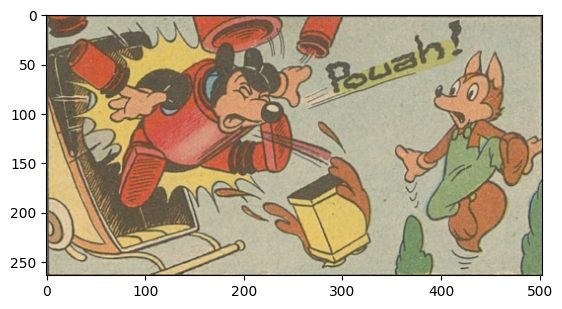

In [58]:
plt.imshow(im)

Panoptic segmentation (top), instance segmentation (middle), semantic segmentation (bottom)


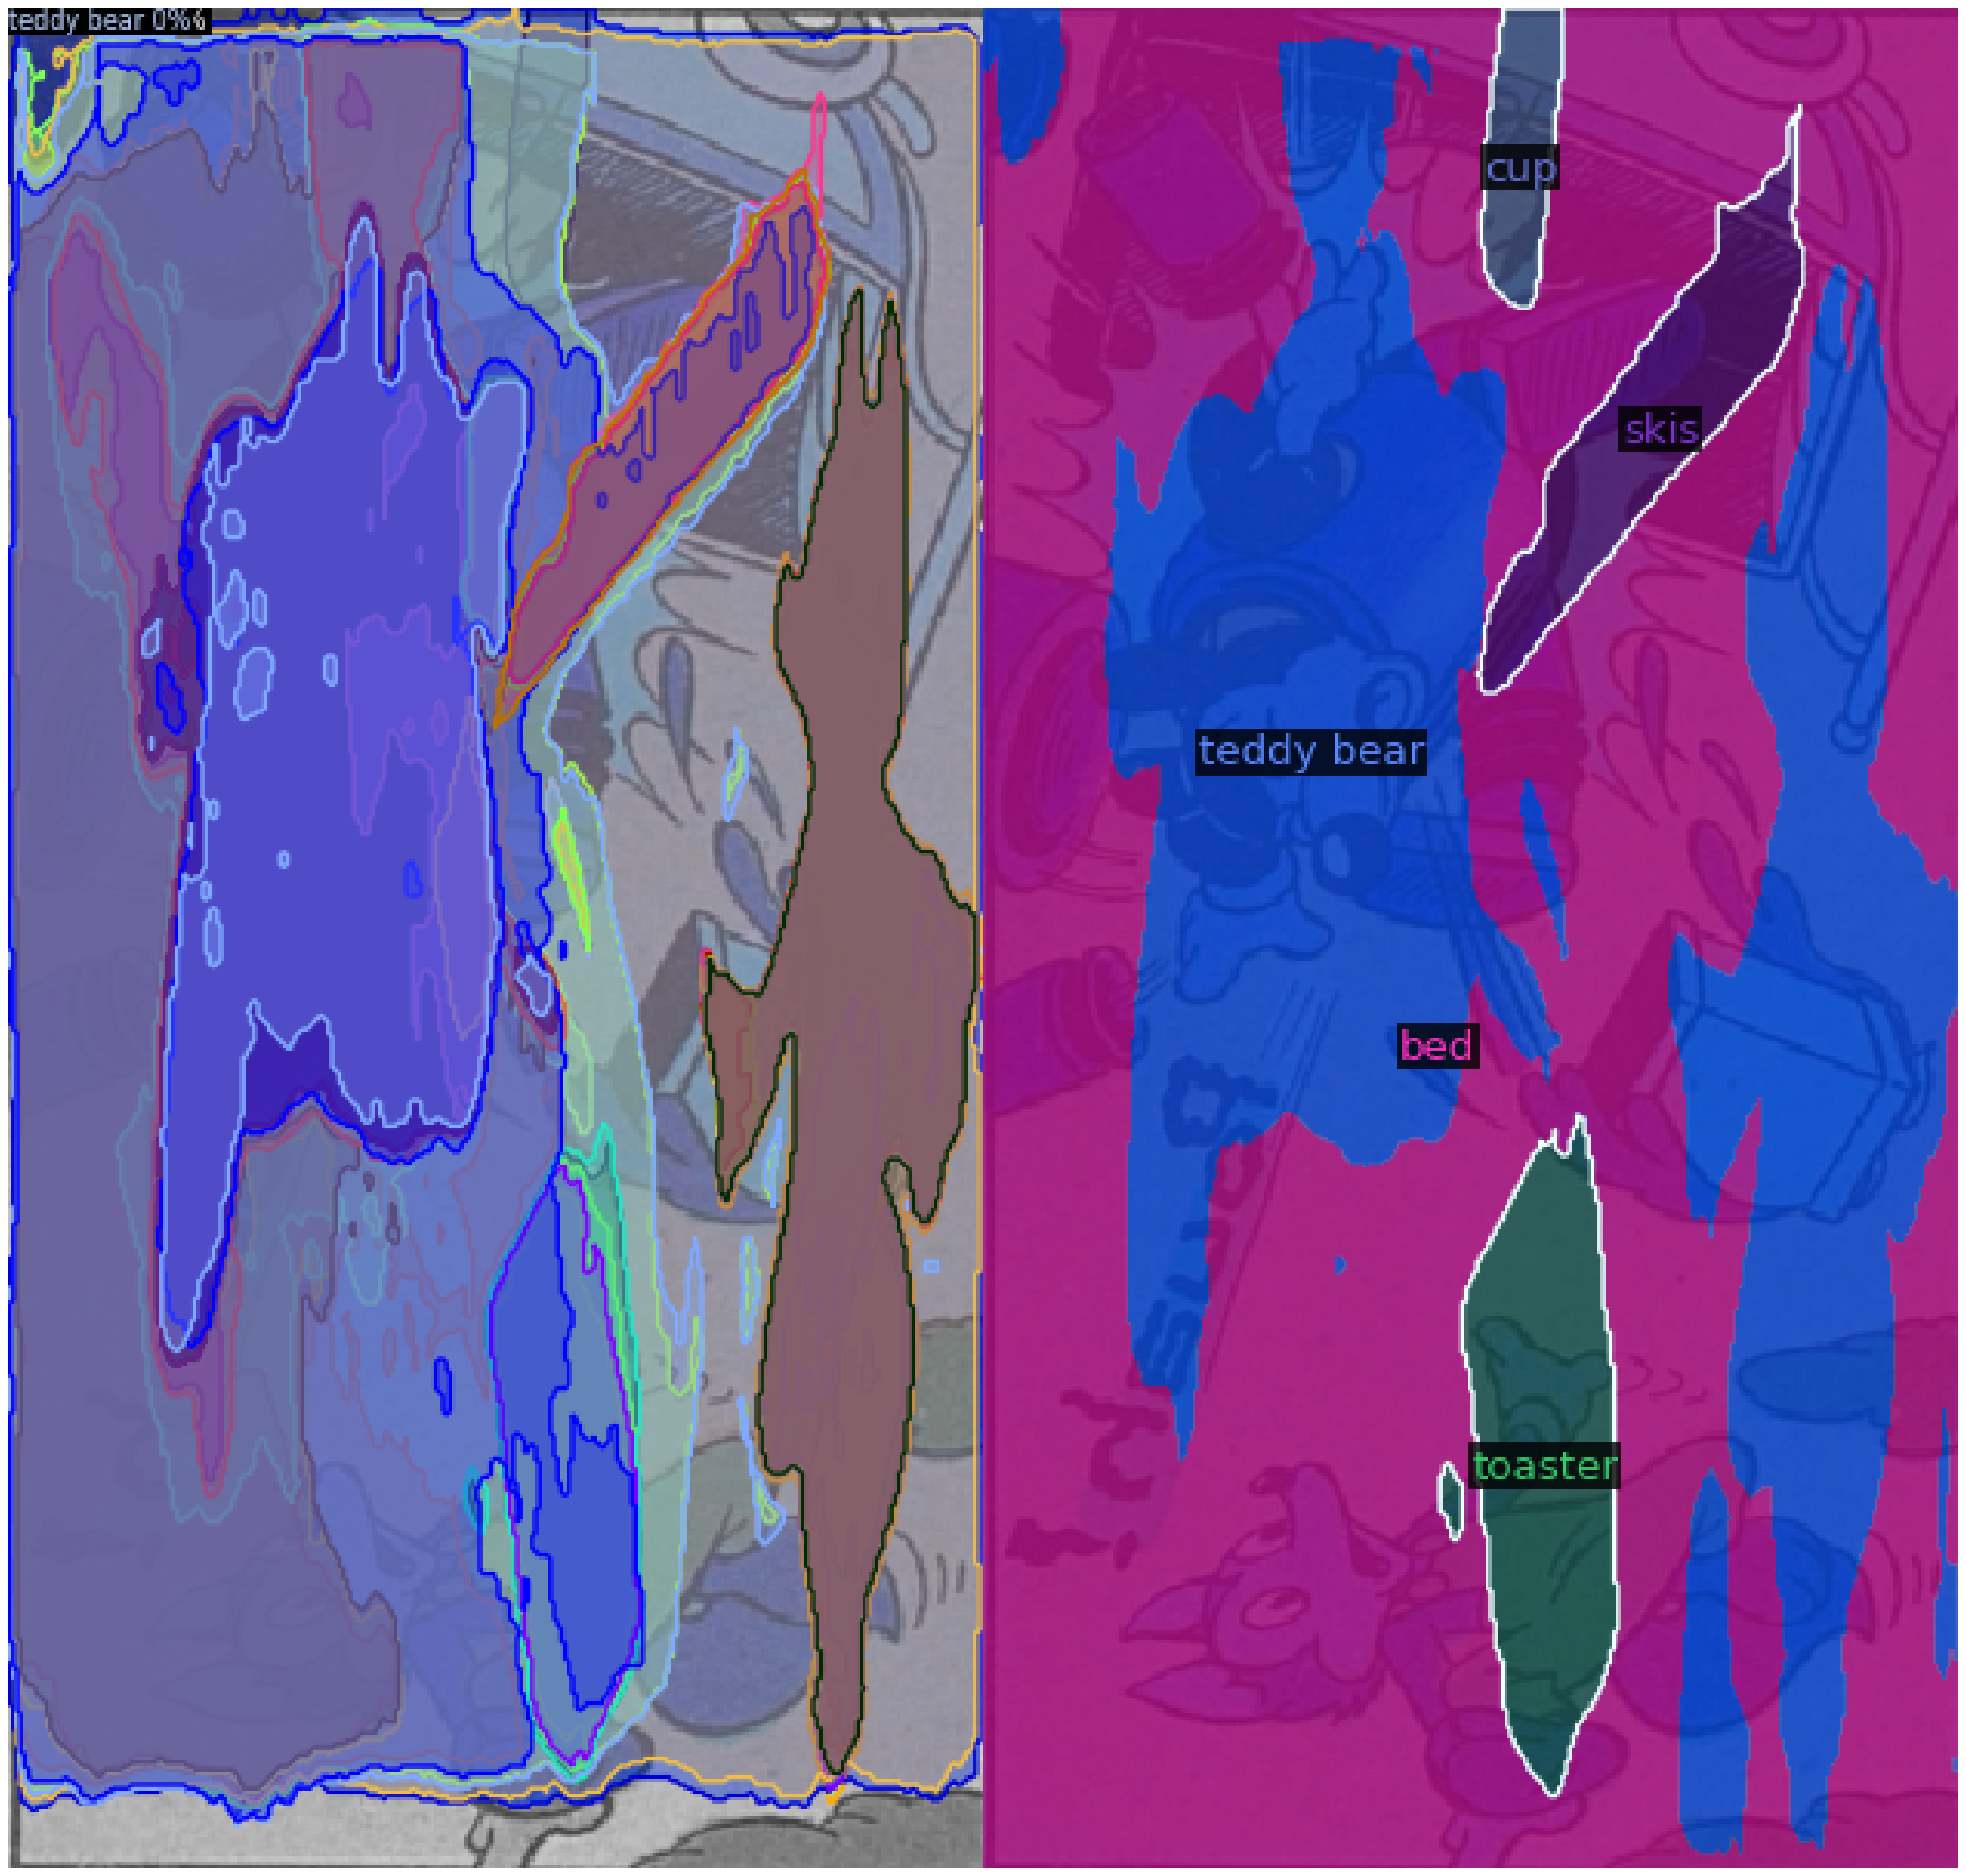

In [59]:
from src.dataset.helpers import *
im = panel['image'].cpu().numpy().transpose(2, 1, 0)

v = Visualizer(im, coco_metadata, scale=1.2, instance_mode=ColorMode.IMAGE_BW)
instance_result = v.draw_instance_predictions(outputs["instances"].to("cpu")).get_image()
v = Visualizer(im, coco_metadata, scale=1.2, instance_mode=ColorMode.IMAGE_BW)
semantic_result = v.draw_sem_seg(outputs["sem_seg"].argmax(0).to("cpu")).get_image()
print("Panoptic segmentation (top), instance segmentation (middle), semantic segmentation (bottom)")
res = np.concatenate((instance_result, semantic_result), axis=1)[:, :, ::-1]
plt.figure(figsize=(40, 30))
plt.imshow(res)
plt.axis('off')
plt.show()

In [31]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = ComicTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[08/23 14:11:19 d2.engine.defaults]: Model:
MaskFormer(
  (backbone): D2SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=192, out_features=576, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=192, out_features=192, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (

RuntimeError: CUDA out of memory. Tried to allocate 494.00 MiB (GPU 0; 39.45 GiB total capacity; 37.01 GiB already allocated; 68.31 MiB free; 37.15 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [30]:
torch.cuda.empty_cache()